# CM3720 - Machine Learning Assignment | Colombo Daily Rental Price Predictor
### 225544G - Subramaniam A

## Problem Statement

Accurately predicting rental prices is a critical task for property owners, real estate agents, and tenants in making informed financial decisions. Rental prices are influenced by multiple factors such as property size, number of bedrooms and bathrooms, neighborhood, proximity to the city center, furnishing status, building type, and property age. 

The challenge is to develop a predictive model that can estimate the rental price of a property based on these features, while capturing potential non-linear relationships and interactions between variables. 

This project explores unconventional and experimental modeling approaches beyond traditional regression and ensemble methods to achieve robust and accurate rental price predictions in Sri Lanka.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Loading the Dataset

In [6]:
df = pd.read_csv("./colombo_rental_dataset_v1.csv")
df.head()

,Property_ID,Size_in_Sqft,Bedrooms,Bathrooms,Neighborhood,Furnished,Building_Type,Rental_Price,Property_Age,Distance_to_City_Center
0,1,692,1.0,2,Uptown,Furnished,Apartment,3035.497680,19,2.07
1,2,622,3.0,1,Suburbs,Unfurnished,Condo,4316.686202,6,10.85
2,3,559,1.0,1,Downtown,Furnished,Studio,2211.047997,5,10.55
3,4,307,1.0,1,Uptown,Furnished,Studio,2330.542651,2,7.37
4,5,1097,3.0,2,uptown,Unfurnished,Apartment,5272.940908,16,7.41


## Data Dictionary

| Column Name               | Data Type | Description                                                                                  |
|---------------------------|-----------|----------------------------------------------------------------------------------------------|
| Property_ID               | int64     | Unique identifier for each property                                                          |
| Size_in_Sqft              | int64     | Total area of the property in square feet                                                    |
| Bedrooms                  | float64   | Number of bedrooms in the property                                                           |
| Bathrooms                 | int64     | Number of bathrooms in the property                                                         |
| Neighborhood              | object    | The area or locality where the property is located                                           |
| Furnished                 | object    | Indicates if the property is furnished or not                                       |
| Building_Type             | object    | Type of the building (e.g., Apartment, House, Condo)               |
| Rental_Price              | float64   | Monthly rental price of the property (target variable)                                       |
| Property_Age              | int64     | Age of the property in years                                                                 |
| Distance_to_City_Center   | float64   | Distance of the property from the city center in kilometers                                  |


## Initial Exploration

In [10]:
len(df)

445

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Property_ID              445 non-null    int64  
 1   Size_in_Sqft             445 non-null    int64  
 2   Bedrooms                 434 non-null    float64
 3   Bathrooms                445 non-null    int64  
 4   Neighborhood             445 non-null    object 
 5   Furnished                445 non-null    object 
 6   Building_Type            440 non-null    object 
 7   Rental_Price             445 non-null    float64
 8   Property_Age             445 non-null    int64  
 9   Distance_to_City_Center  445 non-null    float64
dtypes: float64(3), int64(4), object(3)
memory usage: 34.9+ KB


In [14]:
df.describe()

,Property_ID,Size_in_Sqft,Bedrooms,Bathrooms,Rental_Price,Property_Age,Distance_to_City_Center
count,445.000000,445.000000,434.000000,445.000000,445.000000,445.000000,445.000000
mean,224.734831,794.869663,2.006912,1.244944,3864.158134,12.080899,6.732921
std,130.070275,304.786044,9.558979,0.430538,1997.709703,6.347144,3.614542
min,1.000000,301.000000,1.000000,1.000000,804.814268,1.000000,0.170000
25%,113.000000,557.000000,1.000000,1.000000,2330.542651,7.000000,3.490000
50%,224.000000,785.000000,1.000000,1.000000,3595.205296,11.000000,6.910000
75%,337.000000,1012.000000,2.000000,1.000000,4923.971991,17.000000,9.660000
max,452.000000,1497.000000,200.000000,2.000000,13179.276580,30.000000,14.930000


In [16]:
df.isna().sum()

Property_ID                 0
Size_in_Sqft                0
Bedrooms                   11
Bathrooms                   0
Neighborhood                0
Furnished                   0
Building_Type               5
Rental_Price                0
Property_Age                0
Distance_to_City_Center     0
dtype: int64

#### Note: 
We have missing values in Bedrooms and Building_Type 

In [19]:
df.duplicated().sum()

0

In [21]:
df.dtypes

Property_ID                  int64
Size_in_Sqft                 int64
Bedrooms                   float64
Bathrooms                    int64
Neighborhood                object
Furnished                   object
Building_Type               object
Rental_Price               float64
Property_Age                 int64
Distance_to_City_Center    float64
dtype: object

#### Note:

Since Property_ID is just a unique identifier, it doesn’t help with prediction, so we can safely drop it.

In [24]:
df = df.drop(columns=['Property_ID'])

In [26]:
df.head()

,Size_in_Sqft,Bedrooms,Bathrooms,Neighborhood,Furnished,Building_Type,Rental_Price,Property_Age,Distance_to_City_Center
0,692,1.0,2,Uptown,Furnished,Apartment,3035.497680,19,2.07
1,622,3.0,1,Suburbs,Unfurnished,Condo,4316.686202,6,10.85
2,559,1.0,1,Downtown,Furnished,Studio,2211.047997,5,10.55
3,307,1.0,1,Uptown,Furnished,Studio,2330.542651,2,7.37
4,1097,3.0,2,uptown,Unfurnished,Apartment,5272.940908,16,7.41


In [28]:
df["Neighborhood"].value_counts()

Neighborhood
Midtown     122
Uptown      117
Suburbs     100
Downtown     94
uptown        7
suburbs       5
Name: count, dtype: int64

#### Note:

Neighborhood column has inconsistent capitalization: "Uptown" vs "uptown", "Suburbs" vs "suburbs". This causes the same category to appear multiple times.

In [31]:
df['Neighborhood'] = df['Neighborhood'].str.strip().str.title()

print(df['Neighborhood'].value_counts())

Neighborhood
Uptown      124
Midtown     122
Suburbs     105
Downtown     94
Name: count, dtype: int64


In [33]:
df["Building_Type"].value_counts()

Building_Type
Condo        148
Apartment    142
Studio       142
condo          5
apartment      3
Name: count, dtype: int64

In [35]:
df['Building_Type'] = df['Building_Type'].str.strip().str.title()

print(df['Building_Type'].value_counts())

Building_Type
Condo        153
Apartment    145
Studio       142
Name: count, dtype: int64


In [37]:

df['Furnished'].value_counts()

Furnished
Furnished      296
Unfurnished    138
unfurnished     10
furnished        1
Name: count, dtype: int64

In [39]:
df['Furnished'] = df['Furnished'].str.strip().str.title()

print(df['Furnished'].value_counts())

Furnished
Furnished      297
Unfurnished    148
Name: count, dtype: int64


### Handling Missing Values

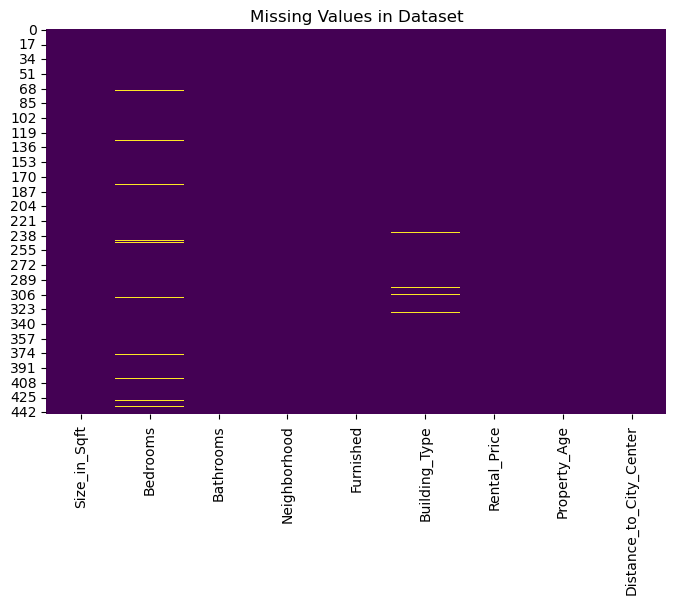

In [42]:
plt.figure(figsize=(8,5))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in Dataset")
plt.show()


In [43]:
from scipy.stats import ttest_ind

missing = df[df['Bedrooms'].isnull()]['Rental_Price']
observed = df[df['Bedrooms'].notnull()]['Rental_Price']

t_stat, p_val = ttest_ind(missing, observed, nan_policy='omit')
print(f"P-value: {p_val}")


P-value: 0.8735087840911885


In [44]:
from scipy.stats import chi2_contingency

missing_bt = df['Building_Type'].isnull().astype(int)
ct = pd.crosstab(missing_bt, df['Neighborhood'])
chi2, p, dof, ex = chi2_contingency(ct)
print(f"P-value: {p}")


P-value: 0.36665769874986764


#### Note:

Both the missing values are Missing Completely at Random. Therefore filling Bedrooms with Median and Building Type with Mode.

In [49]:
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy='median')
df['Bedrooms'] = num_imputer.fit_transform(df[['Bedrooms']]).astype('int64')

cat_imputer = SimpleImputer(strategy='most_frequent')
df['Building_Type'] = cat_imputer.fit_transform(df[['Building_Type']]).ravel() 

print(df.isnull().sum())


Size_in_Sqft               0
Bedrooms                   0
Bathrooms                  0
Neighborhood               0
Furnished                  0
Building_Type              0
Rental_Price               0
Property_Age               0
Distance_to_City_Center    0
dtype: int64


In [50]:
print(df.dtypes)

Size_in_Sqft                 int64
Bedrooms                     int64
Bathrooms                    int64
Neighborhood                object
Furnished                   object
Building_Type               object
Rental_Price               float64
Property_Age                 int64
Distance_to_City_Center    float64
dtype: object


## Univariate Analysis

### Univariate Analysis - Numeric Columns

       Size_in_Sqft    Bedrooms   Bathrooms  Property_Age  \
count    445.000000  445.000000  445.000000    445.000000   
mean     794.869663    1.982022    1.244944     12.080899   
std      304.786044    9.441123    0.430538      6.347144   
min      301.000000    1.000000    1.000000      1.000000   
25%      557.000000    1.000000    1.000000      7.000000   
50%      785.000000    1.000000    1.000000     11.000000   
75%     1012.000000    2.000000    1.000000     17.000000   
max     1497.000000  200.000000    2.000000     30.000000   

       Distance_to_City_Center  
count               445.000000  
mean                  6.732921  
std                   3.614542  
min                   0.170000  
25%                   3.490000  
50%                   6.910000  
75%                   9.660000  
max                  14.930000  


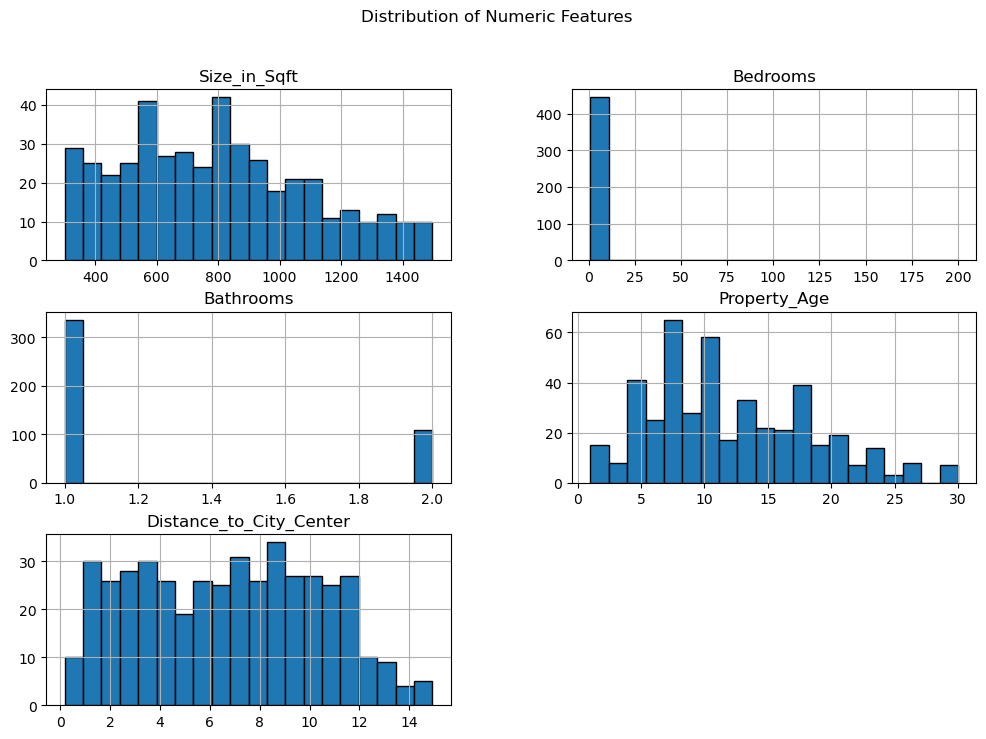

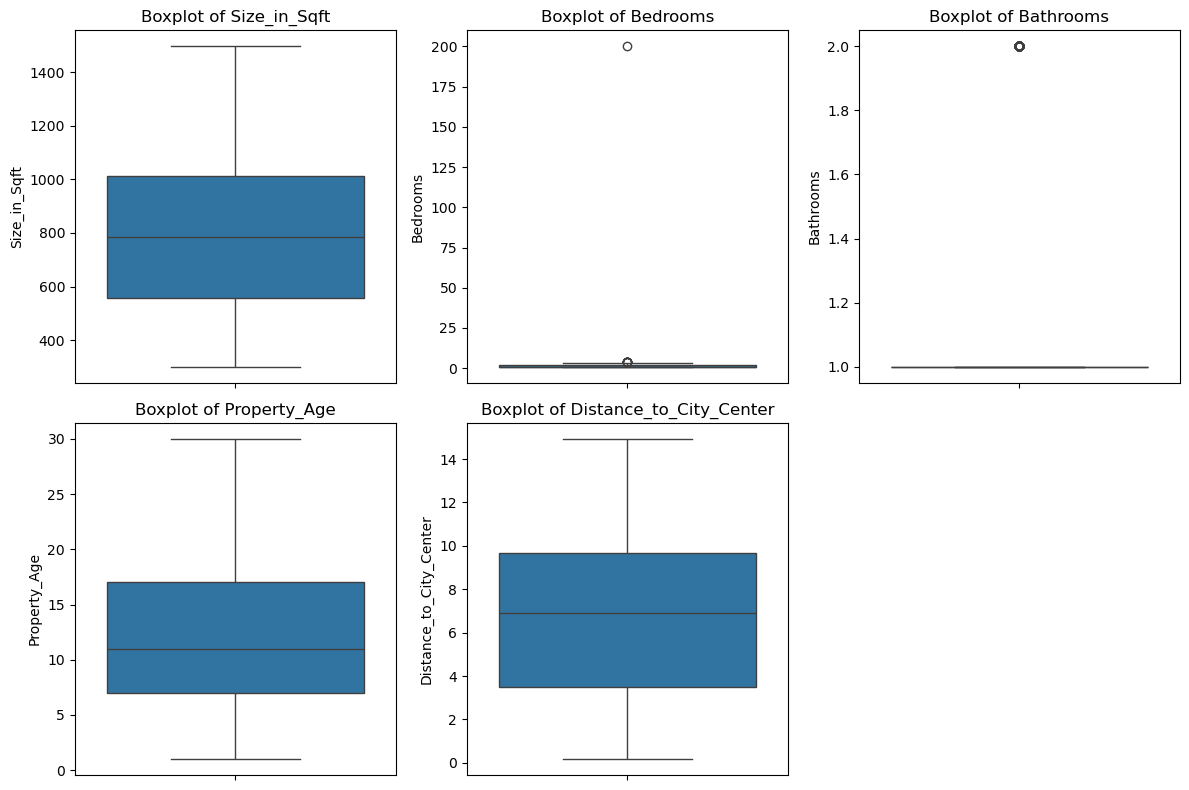

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = ['Size_in_Sqft', 'Bedrooms', 'Bathrooms', 'Property_Age', 'Distance_to_City_Center']

print(df[num_cols].describe())

df[num_cols].hist(figsize=(12,8), bins=20, edgecolor='black')
plt.suptitle("Distribution of Numeric Features")
plt.show()

plt.figure(figsize=(12,8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2,3,i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


### Note

The above visualization suggests there could be a potential outlier in the features Bedrooms and Bathrooms

### Outlier Handling

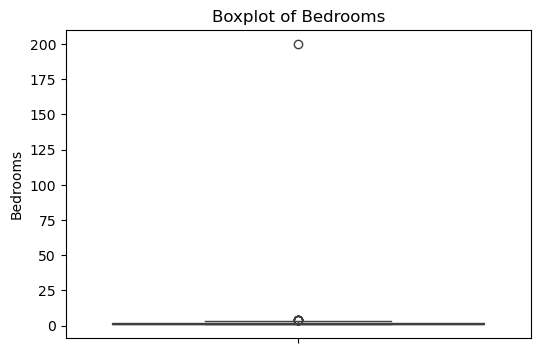

In [58]:
plt.figure(figsize=(6,4))
sns.boxplot(y=df['Bedrooms'])
plt.title("Boxplot of Bedrooms")
plt.show()

In [59]:
max(df["Bedrooms"])

200

### Note

The value 200 for Bedrooms is definitely should be a data entry error. Therefore, that should be removed

In [61]:
df = df[df['Bedrooms'] != 200]

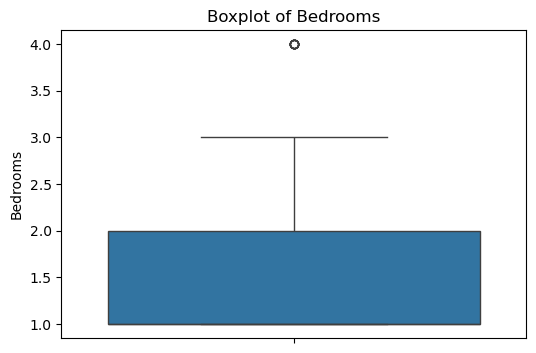

In [66]:
plt.figure(figsize=(6,4))
sns.boxplot(y=df['Bedrooms'])
plt.title("Boxplot of Bedrooms")
plt.show()

In [68]:
df["Bedrooms"].value_counts()

Bedrooms
1    280
2     99
3     56
4      9
Name: count, dtype: int64

In [70]:
df["Bathrooms"].value_counts()

Bathrooms
1    335
2    109
Name: count, dtype: int64

In [72]:
df = df[df['Rental_Price'] < df['Rental_Price'].quantile(0.99)]
df = df[df['Size_in_Sqft'] < df['Size_in_Sqft'].quantile(0.99)]

### Univariate Analysis - Categorical Columns


Value counts for Neighborhood:
Neighborhood
Uptown      121
Midtown     117
Suburbs     102
Downtown     94
Name: count, dtype: int64


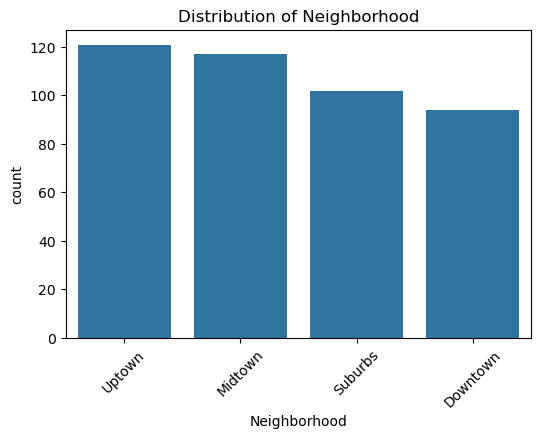


Value counts for Furnished:
Furnished
Furnished      291
Unfurnished    143
Name: count, dtype: int64


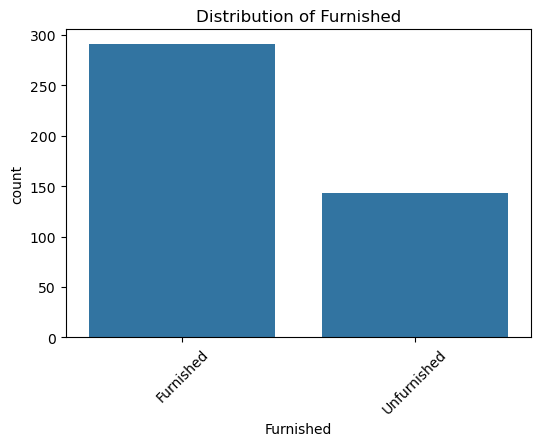


Value counts for Building_Type:
Building_Type
Condo        152
Studio       142
Apartment    140
Name: count, dtype: int64


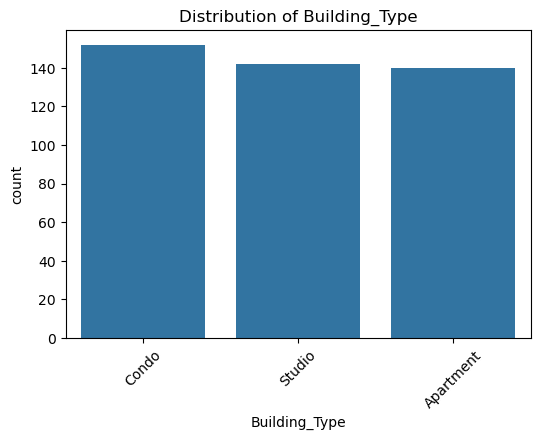

In [75]:
cat_cols = ['Neighborhood', 'Furnished', 'Building_Type']

for col in cat_cols:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())
    
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()


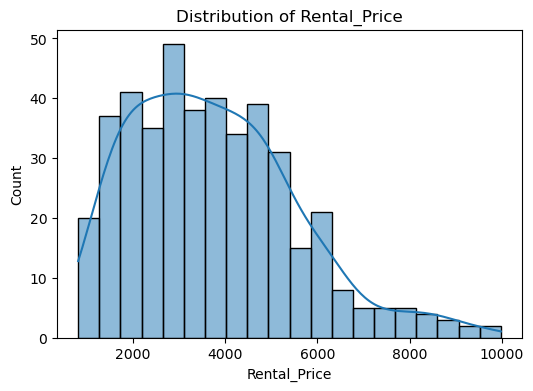

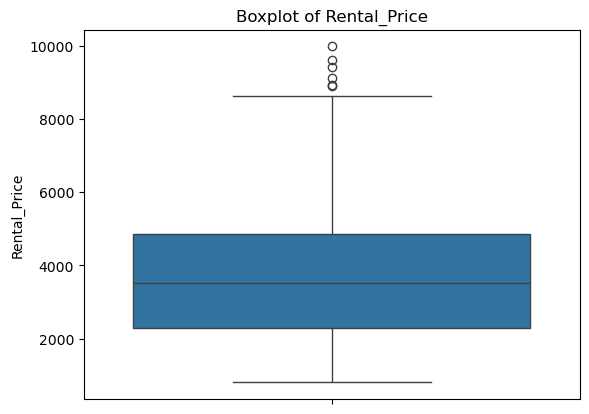

In [77]:
plt.figure(figsize=(6,4))
sns.histplot(df['Rental_Price'], bins=20, kde=True)
plt.title("Distribution of Rental_Price")
plt.show()

sns.boxplot(y=df['Rental_Price'])
plt.title("Boxplot of Rental_Price")
plt.show()

Observation:  Rental Price is positively skewed

### Bi Variate Analysis

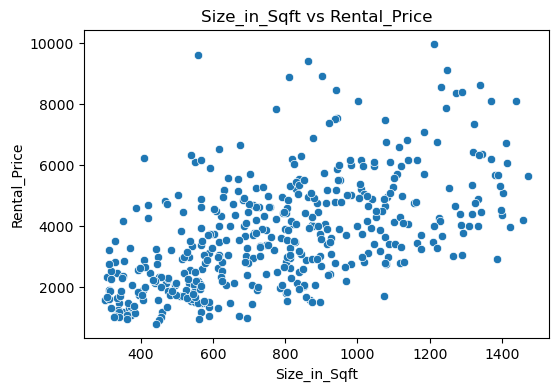

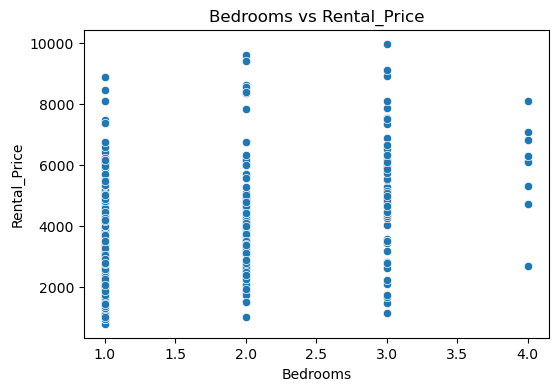

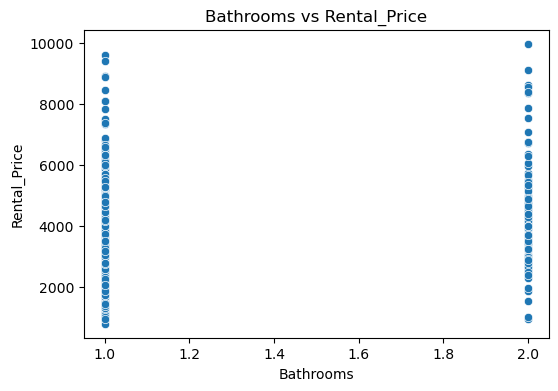

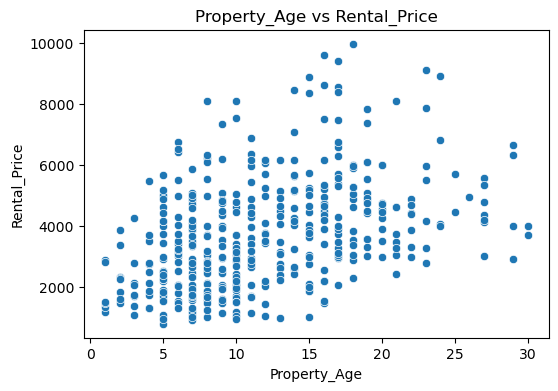

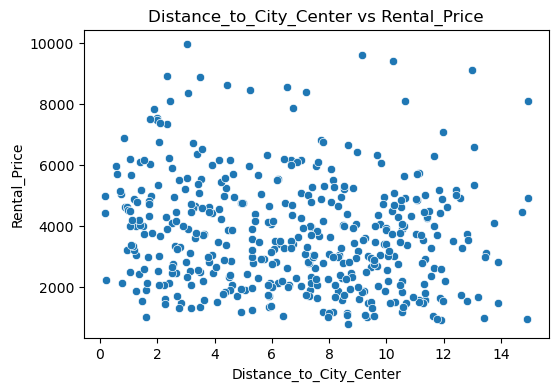

In [81]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[col], y=df['Rental_Price'])
    plt.title(f"{col} vs Rental_Price")
    plt.show()


Observation - There is a linear relationship between size and rental price

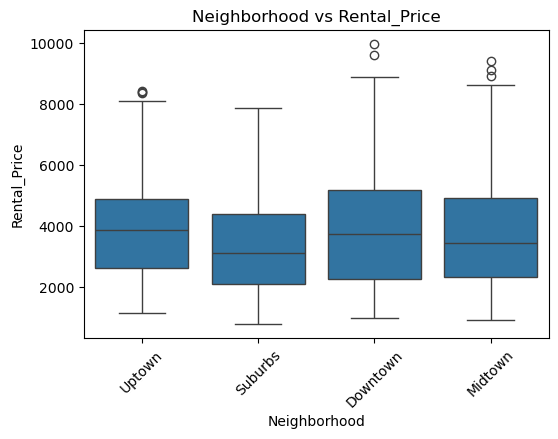

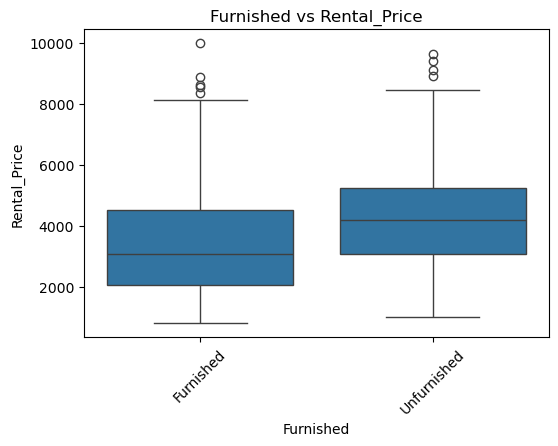

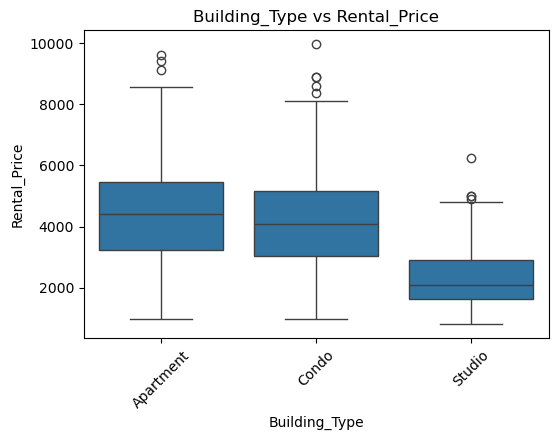

In [84]:
cat_cols = ['Neighborhood', 'Furnished', 'Building_Type']

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col], y=df['Rental_Price'])
    plt.title(f"{col} vs Rental_Price")
    plt.xticks(rotation=45)
    plt.show()


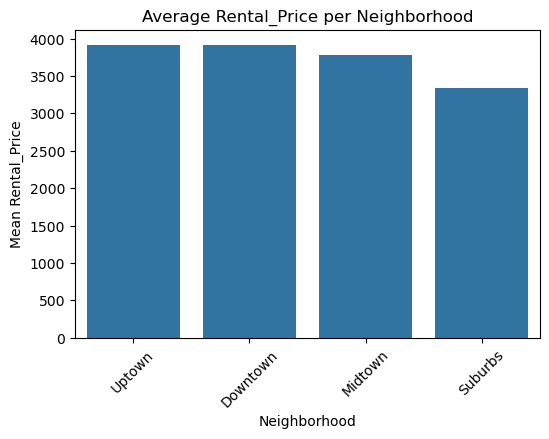

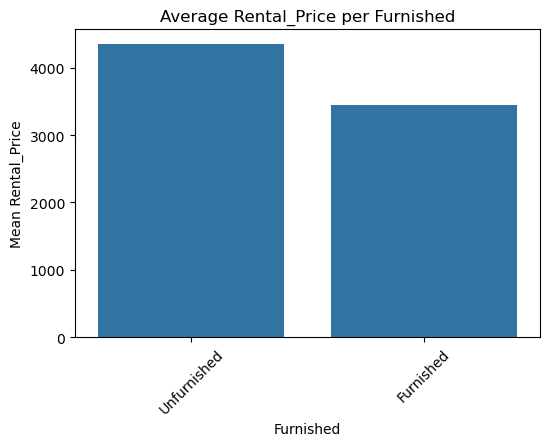

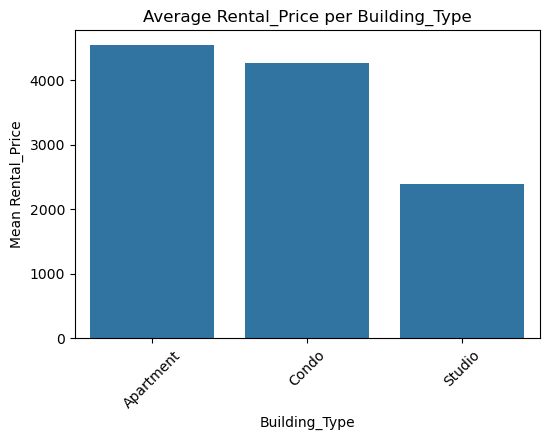

In [85]:
for col in cat_cols:
    mean_prices = df.groupby(col)['Rental_Price'].mean().sort_values(ascending=False)
    plt.figure(figsize=(6,4))
    sns.barplot(x=mean_prices.index, y=mean_prices.values)
    plt.title(f"Average Rental_Price per {col}")
    plt.xticks(rotation=45)
    plt.ylabel("Mean Rental_Price")
    plt.show()

Observation - Apartment Houses tend to have higer rental price

### Multi Variate Analysis

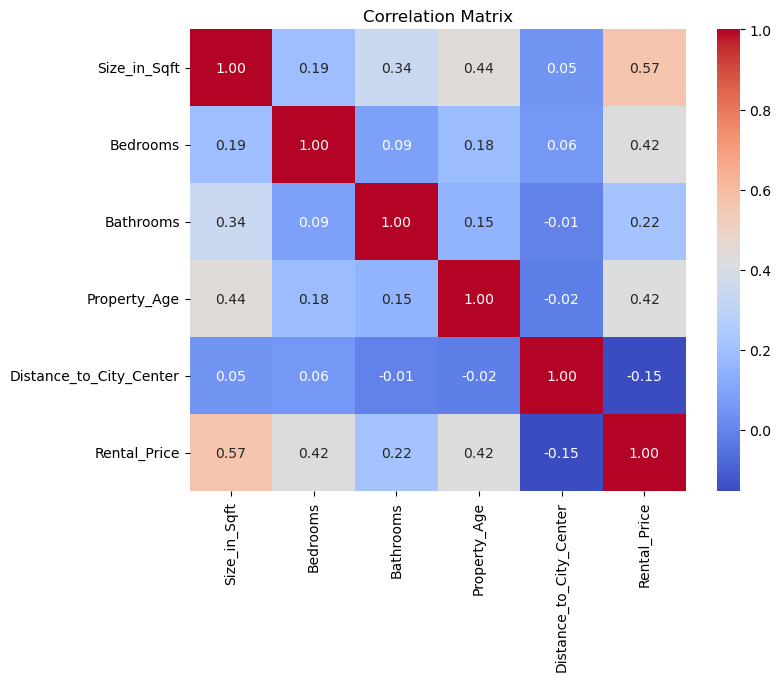

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ['Size_in_Sqft', 'Bedrooms', 'Bathrooms', 'Property_Age', 'Distance_to_City_Center', 'Rental_Price']

corr = df[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


## Predictive Modelling

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [95]:
num_cols = ['Size_in_Sqft', 'Bedrooms', 'Bathrooms', 'Property_Age', 'Distance_to_City_Center']
cat_cols = ['Neighborhood', 'Furnished', 'Building_Type']

In [97]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

In [99]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

In [101]:
X = df.drop('Rental_Price', axis=1)
y = df['Rental_Price']

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Evaluating models...


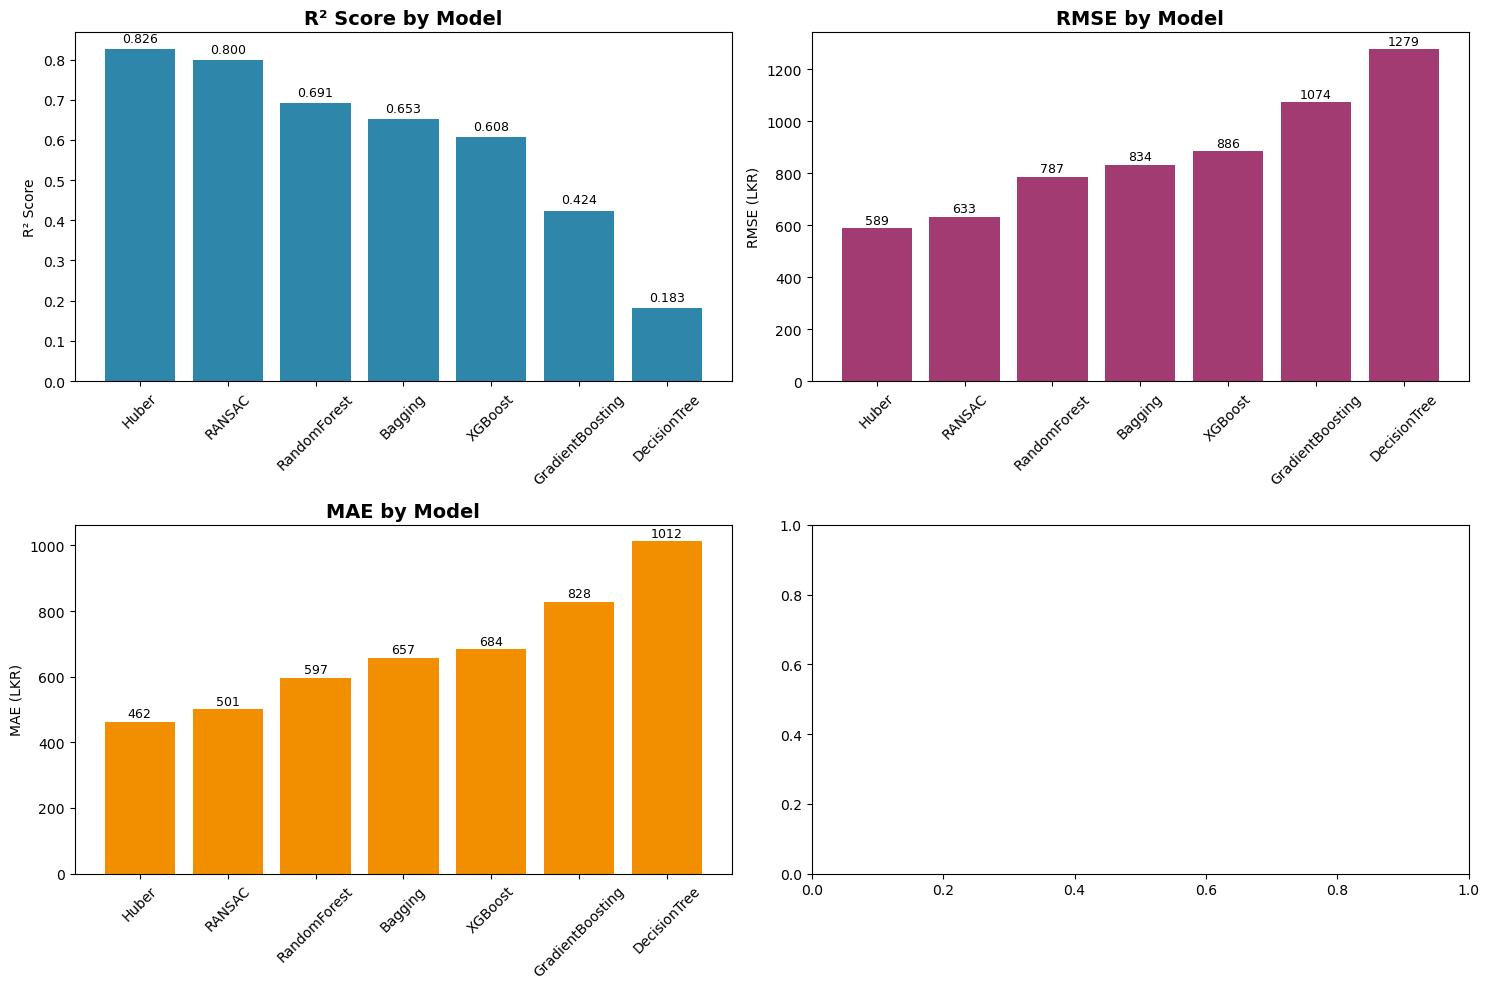


MODEL PERFORMANCE SUMMARY
Model           R²       RMSE       MAE       
--------------------------------------------------
Huber           0.8265   589        462       
RANSAC          0.7998   633        501       
RandomForest    0.6908   787        597       
Bagging         0.6531   834        657       
XGBoost         0.6078   886        684       
GradientBoosting 0.4244   1074       828       
DecisionTree    0.1830   1279       1012      

TOP 3 MODELS:
1. Huber: R² = 0.8265, RMSE = 589 LKR
2. RANSAC: R² = 0.7998, RMSE = 633 LKR
3. RandomForest: R² = 0.6908, RMSE = 787 LKR


In [105]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import HuberRegressor, TheilSenRegressor, PassiveAggressiveRegressor, RANSACRegressor
import numpy as np
import matplotlib.pyplot as plt
import time

models = {
    "Huber": HuberRegressor(epsilon=1.35, alpha=0.0001, max_iter=1000),
    "RANSAC": RANSACRegressor(min_samples=0.5, residual_threshold=None, random_state=42),
    
    "DecisionTree": DecisionTreeRegressor(max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_split=5, 
                                        min_samples_leaf=2, max_features='sqrt', 
                                        random_state=42, n_jobs=1),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, 
                                                max_depth=6, min_samples_split=5,
                                                min_samples_leaf=2, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, 
                          min_child_weight=2, subsample=0.8, colsample_bytree=0.8,
                          random_state=42, n_jobs=1),
    "Bagging": BaggingRegressor(
        estimator=DecisionTreeRegressor(max_depth=15, random_state=42),
        n_estimators=50, max_samples=0.8, max_features=0.8, random_state=42, n_jobs=1
    )
}

def evaluate_models_simple(X_train, X_test, y_train, y_test, preprocessor):
    results = {}
    
    for name, model in models.items():
        start_time = time.time()
        
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        training_time = time.time() - start_time

        results[name] = {
            'rmse': rmse, 
            'mae': mae, 
            'r2': r2,
            'training_time': training_time
        }
    
    return results

print("Evaluating models...")
results = evaluate_models_simple(X_train, X_test, y_train, y_test, preprocessor)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sorted_models = sorted(results.items(), key=lambda x: x[1]['r2'], reverse=True)
model_names = [x[0] for x in sorted_models]
r2_scores = [x[1]['r2'] for x in sorted_models]
mae_scores = [x[1]['mae'] for x in sorted_models]
rmse_scores = [x[1]['rmse'] for x in sorted_models]
training_times = [x[1]['training_time'] for x in sorted_models]

bars = axes[0,0].bar(model_names, r2_scores, color='#2E86AB')
axes[0,0].set_title('R² Score by Model', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('R² Score')
axes[0,0].tick_params(axis='x', rotation=45)
for bar, score in zip(bars, r2_scores):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                  f'{score:.3f}', ha='center', va='bottom', fontsize=9)

bars = axes[0,1].bar(model_names, rmse_scores, color='#A23B72')
axes[0,1].set_title('RMSE by Model', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('RMSE (LKR)')
axes[0,1].tick_params(axis='x', rotation=45)
for bar, score in zip(bars, rmse_scores):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                  f'{score:.0f}', ha='center', va='bottom', fontsize=9)

bars = axes[1,0].bar(model_names, mae_scores, color='#F18F01')
axes[1,0].set_title('MAE by Model', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('MAE (LKR)')
axes[1,0].tick_params(axis='x', rotation=45)
for bar, score in zip(bars, mae_scores):
    axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                  f'{score:.0f}', ha='center', va='bottom', fontsize=9)


plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("MODEL PERFORMANCE SUMMARY")
print("="*50)
print(f"{'Model':<15} {'R²':<8} {'RMSE':<10} {'MAE':<10}")
print("-"*50)
for name, metrics in sorted_models:
    print(f"{name:<15} {metrics['r2']:<8.4f} {metrics['rmse']:<10.0f} {metrics['mae']:<10.0f}")

print(f"\nTOP 3 MODELS:")
for i, (name, metrics) in enumerate(sorted_models[:3], 1):
    print(f"{i}. {name}: R² = {metrics['r2']:.4f}, RMSE = {metrics['rmse']:.0f} LKR")

## Improving the Performance

In [107]:

ensemble1 = VotingRegressor([
    ('huber', HuberRegressor(epsilon=1.35, alpha=0.0001, max_iter=1000)),
    ('ransac', RANSACRegressor(min_samples=0.5, residual_threshold=None, random_state=42))
], weights=[1, 1])

ensemble2 = VotingRegressor([
    ('huber', HuberRegressor(epsilon=1.35, alpha=0.0001, max_iter=1000)),
    ('ransac', RANSACRegressor(min_samples=0.5, residual_threshold=None, random_state=42))
], weights=[2, 1])

ensemble3 = VotingRegressor([
    ('huber', HuberRegressor(epsilon=1.35, alpha=0.0001, max_iter=1000)),
    ('ransac', RANSACRegressor(min_samples=0.5, residual_threshold=None, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_split=5, 
                               min_samples_leaf=2, max_features='sqrt', random_state=42, n_jobs=-1))
], weights=[3, 2, 1])

ensembles = {
    'Equal_Weights': ensemble1,
    'Huber_Favored': ensemble2,
    'With_RF': ensemble3
}

ensemble_results = {}

for name, ensemble_model in ensembles.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', ensemble_model)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    ensemble_results[name] = {'r2': r2, 'rmse': rmse}
    
    print(f"{name}: R² = {r2:.4f}, RMSE = {rmse:.0f}")

best_ensemble_name = max(ensemble_results.items(), key=lambda x: x[1]['r2'])
print(f"\nBest ensemble: {best_ensemble_name[0]} - R²: {best_ensemble_name[1]['r2']:.4f}")

Equal_Weights: R² = 0.8176, RMSE = 604
Huber_Favored: R² = 0.8216, RMSE = 598
With_RF: R² = 0.8209, RMSE = 599

Best ensemble: Huber_Favored - R²: 0.8216


## Hyper Parameter Tuning

In [109]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'model__weights': [
        [1, 1],    
        [2, 1],    
        [3, 1], 
        [1, 2],    
        [3, 2]     
    ]
}

base_ensemble = VotingRegressor([
    ('huber', HuberRegressor(epsilon=1.35, alpha=0.0001, max_iter=1000)),
    ('ransac', RANSACRegressor(min_samples=0.5, residual_threshold=None, random_state=42))
])

ensemble_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', base_ensemble)
])

ensemble_search = RandomizedSearchCV(
    ensemble_pipe,
    param_dist,
    n_iter=5,  
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=1
)

ensemble_search.fit(X_train, y_train)

best_ensemble = ensemble_search.best_estimator_
best_weights = ensemble_search.best_params_['model__weights']

y_pred_best_ensemble = best_ensemble.predict(X_test)
best_r2 = r2_score(y_test, y_pred_best_ensemble)
best_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best_ensemble))

print(f"Best ensemble weights: {best_weights}")
print(f"Best ensemble R²: {best_r2:.4f}")
print(f"Best ensemble RMSE: {best_rmse:.0f}")

print(f"\nComparison:")
print(f"Huber:    R² = {results['Huber']['r2']:.4f}")
print(f"RANSAC:   R² = {results['RANSAC']['r2']:.4f}")
print(f"Ensemble: R² = {best_r2:.4f}")

Best ensemble weights: [3, 1]
Best ensemble R²: 0.8232
Best ensemble RMSE: 595

Comparison:
Huber:    R² = 0.8265
RANSAC:   R² = 0.7998
Ensemble: R² = 0.8232


In [110]:
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', VotingRegressor([
        ('huber', HuberRegressor(epsilon=1.35, alpha=0.0001, max_iter=1000)),
        ('ransac', RANSACRegressor(min_samples=0.5, residual_threshold=None, random_state=42))
    ], weights=[3, 1]))
])

final_model.fit(X_train, y_train)

y_pred_final = final_model.predict(X_test)
final_r2 = r2_score(y_test, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))

print("FINAL MODEL SELECTED: Ensemble (Huber + RANSAC)")
print(f"Final R²: {final_r2:.4f}")
print(f"Final RMSE: {final_rmse:.0f} LKR")

import joblib
joblib.dump(final_model, 'best_rental_price_modelv2.pkl')
print("Model saved as 'best_rental_price_model.pkl'")

FINAL MODEL SELECTED: Ensemble (Huber + RANSAC)
Final R²: 0.8232
Final RMSE: 595 LKR
Model saved as 'best_rental_price_model.pkl'


## Model Explainability

In [112]:
import shap
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

final_model = joblib.load('best_rental_price_modelv2.pkl')
preprocessor = final_model.named_steps['preprocessor']
model = final_model.named_steps['model']

feature_names = preprocessor.get_feature_names_out()

X_train_trans = preprocessor.transform(X_train)
X_test_trans = preprocessor.transform(X_test)

X_train_df = pd.DataFrame(X_train_trans, columns=feature_names)
X_test_df = pd.DataFrame(X_test_trans, columns=feature_names)

shap_sample = X_test_df.sample(n=min(100, len(X_test_df)), random_state=42)

explainer = shap.Explainer(model.predict, X_train_df)
shap_values = explainer(shap_sample)

print("SHAP ready!")

SHAP ready!


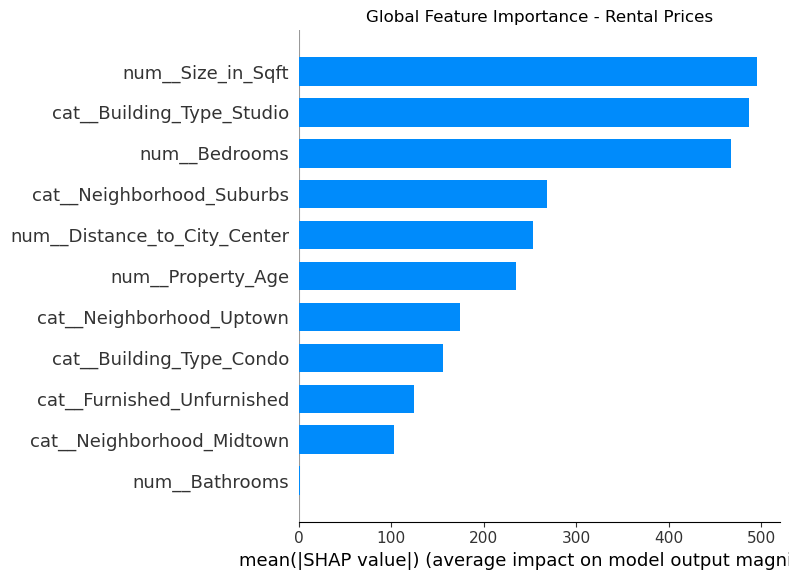

In [113]:
plt.figure(figsize=(12, 7))
shap.summary_plot(shap_values, shap_sample, plot_type="bar", show=False)
plt.title("Global Feature Importance - Rental Prices")
plt.tight_layout()
plt.show()

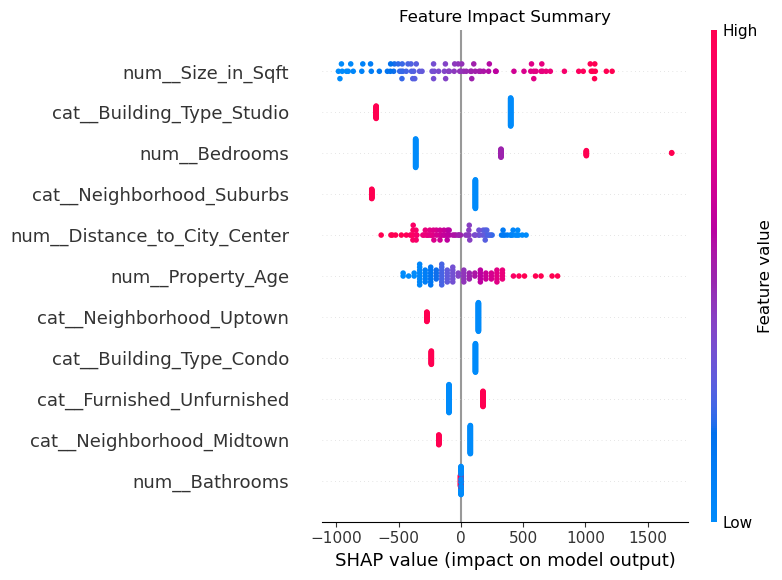

In [114]:
plt.figure(figsize=(12, 7))
shap.summary_plot(shap_values, shap_sample, show=False)
plt.title("Feature Impact Summary")
plt.tight_layout()
plt.show()

In [115]:
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'MeanAbs': np.abs(shap_values.values).mean(0),
    'MeanSHAP': shap_values.values.mean(0)
})

feature_importance['Percent'] = (
    feature_importance['MeanAbs'] / feature_importance['MeanAbs'].sum() * 100
)

feature_importance = feature_importance.sort_values('MeanAbs', ascending=False)

In [117]:
feature_mapping = {
    'num__Size_in_Sqft': 'Property Size',
    'num__Bedrooms': 'Bedrooms',
    'num__Bathrooms': 'Bathrooms',
    'num__Distance_to_City_Center': 'Distance to City',
    'cat__Neighborhood_Downtown': 'Downtown Area',
    'cat__Neighborhood_Suburbs': 'Suburbs',
    'cat__Furnished_Furnished': 'Furnished',
    'cat__Building_Type_Apartment': 'Apartment'
}

top_feature = feature_mapping.get(
    feature_importance.iloc[0]['Feature'],
    feature_importance.iloc[0]['Feature']
)

second_feature = feature_mapping.get(
    feature_importance.iloc[1]['Feature'],
    feature_importance.iloc[1]['Feature']
)

most_negative = (
    feature_importance[feature_importance['MeanSHAP'] < 0]
    .iloc[0]['Feature']
)
most_negative = feature_mapping.get(most_negative, most_negative)

print("\n========================================")
print("BUSINESS INSIGHTS")
print("========================================")

print("\nFor Property Owners:")
print(f" • Improve {top_feature} — biggest driver of rental value")

print("\nFor Tenants:")
print(f" • Properties with better {most_negative} offer better affordability")

print("\nFor Real Estate Agents:")
print(f" • Highlight {top_feature} and {second_feature} in listings")



BUSINESS INSIGHTS

For Property Owners:
 • Improve Property Size — biggest driver of rental value

For Tenants:
 • Properties with better Property Size offer better affordability

For Real Estate Agents:
 • Highlight Property Size and cat__Building_Type_Studio in listings


In [118]:
joblib.dump({
    'feature_importance': feature_importance,
    'top_driver': top_feature,
    'second_driver': second_feature,
    'top_negative': most_negative,
}, 'shap_insights_compact.pkl')

print("\nCompact SHAP insights saved!")


Compact SHAP insights saved!
